In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.cloud import bigquery
from dateutil.parser import parse
import os
from pathlib import Path
from bikesharing.ml_logic.data import get_raw_data, get_polygons
from bikesharing.ml_logic.encoders import encode_district_label
from bikesharing.params import *

In [6]:
data = pd.read_csv(f'{LOCAL_DATA_PATH}/processed/data_with_districts_per_hour.csv')

In [7]:
data.head()

,rental_date_hour,Altstadt-Lehel,Au - Haidhausen,Aubing-Lochhausen-Langwied,Berg am Laim,Bogenhausen,Feldmoching,Hadern,Harlaching,Hasenbergl-Lerchenau Ost,...,Schwanthalerhöhe,Sendling,Sendling-Westpark,Südgiesing,Thalkirchen,Trudering,Trudering-Riem,Untergiesing,Untergiesing-Harlaching,Untermenzing-Allach
0,2019-01-01 00:00:00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2019-01-01 01:00:00,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2,2019-01-01 02:00:00,1.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,5.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,2019-01-01 03:00:00,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
4,2019-01-01 04:00:00,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
data.rental_date_hour = pd.to_datetime(data.rental_date_hour)

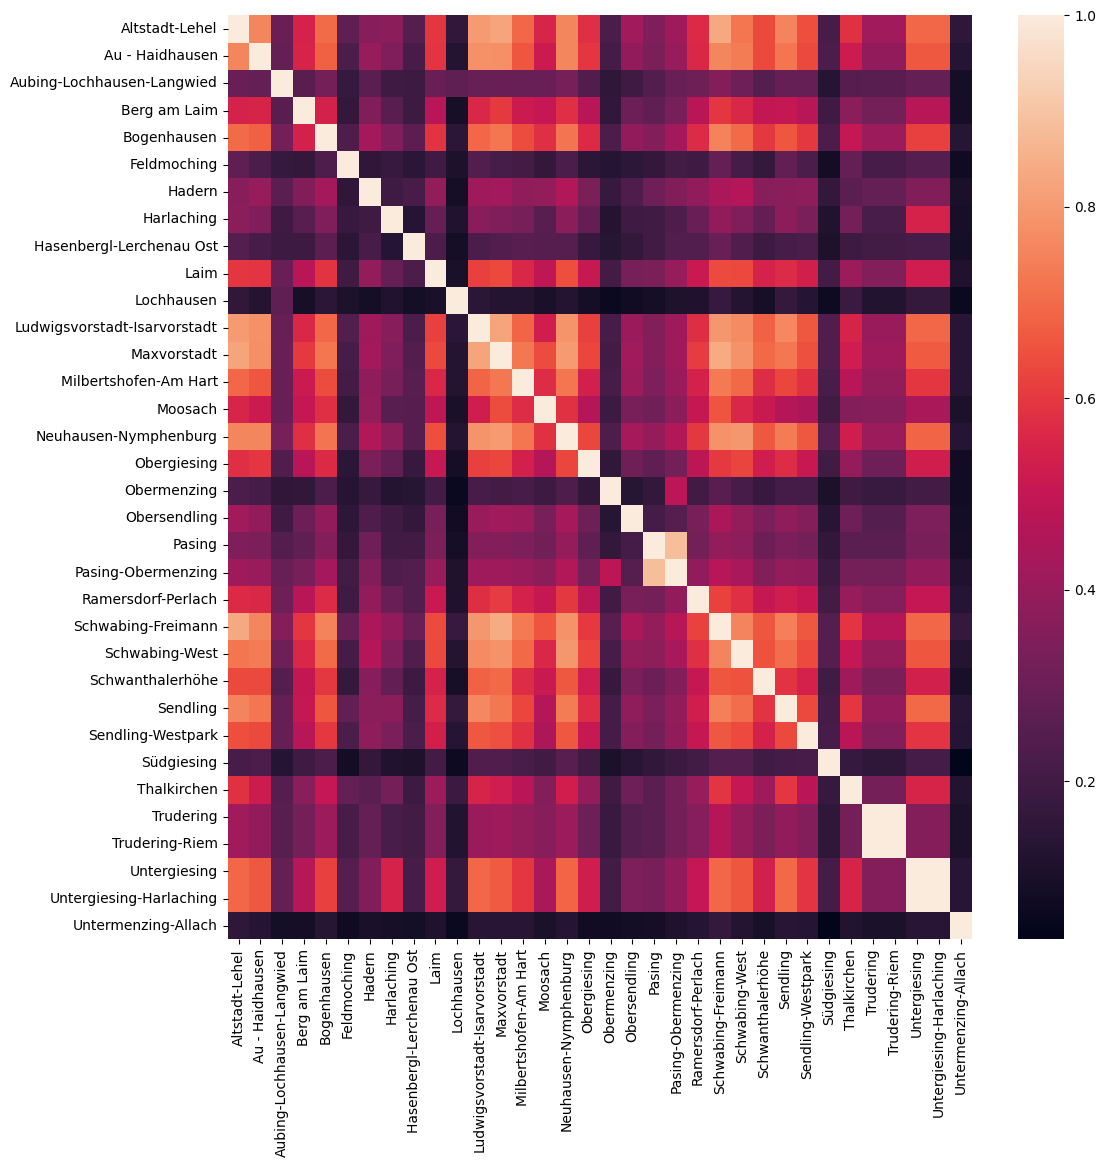

In [25]:
fig, ax = plt.subplots(figsize=(12,12)) 
sns.heatmap(data.drop(columns='rental_date_hour').corr(), ax=ax);

In [26]:
# var(x-y)/var(x)
data.describe()

,rental_date_hour,Altstadt-Lehel,Au - Haidhausen,Aubing-Lochhausen-Langwied,Berg am Laim,Bogenhausen,Feldmoching,Hadern,Harlaching,Hasenbergl-Lerchenau Ost,...,Schwanthalerhöhe,Sendling,Sendling-Westpark,Südgiesing,Thalkirchen,Trudering,Trudering-Riem,Untergiesing,Untergiesing-Harlaching,Untermenzing-Allach
count,34632,34632.000000,34632.000000,34632.000000,34632.000000,34632.000000,34632.000000,34632.000000,34632.000000,34632.000000,...,34632.000000,34632.000000,34632.000000,34632.000000,34632.000000,34632.000000,34632.000000,34632.000000,34632.000000,34632.000000
mean,2021-01-01 00:15:55.509355520,6.716967,3.516314,0.286556,1.191961,2.383085,0.056422,0.598319,0.219364,0.111920,...,2.018220,3.181566,1.570542,0.124942,0.619918,0.330446,0.330446,1.842804,1.842804,0.019577
min,2019-01-01 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2019-12-30 21:45:00,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2020-12-29 02:30:00,4.000000,2.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
75%,2022-01-02 23:15:00,9.000000,5.000000,0.000000,2.000000,3.000000,0.000000,1.000000,0.000000,0.000000,...,3.000000,5.000000,2.000000,0.000000,1.000000,0.000000,0.000000,3.000000,3.000000,0.000000
max,2022-12-31 23:00:00,75.000000,35.000000,11.000000,14.000000,39.000000,7.000000,15.000000,8.000000,9.000000,...,23.000000,38.000000,19.000000,6.000000,26.000000,13.000000,13.000000,24.000000,24.000000,6.000000
std,NaN,8.620787,3.974017,0.730027,1.615558,3.025092,0.295097,1.094285,0.576570,0.394374,...,2.462033,3.999474,2.114272,0.392546,1.291125,0.770781,0.770781,2.511722,2.511722,0.157835
